### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../propensTheory/'
p1 = 'propensTheory/'

base_path = '../results/'+p1

treated = pd.read_pickle(p+'treated2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'matched.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 266 ms, sys: 155 ms, total: 421 ms
Wall time: 507 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201710

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.2 s, sys: 16.5 ms, total: 12.2 s
Wall time: 12.2 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 94 columns]

In [12]:
survTr.shape, survCo.shape

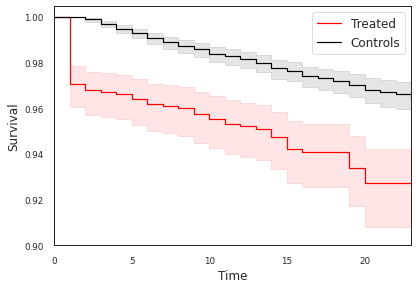

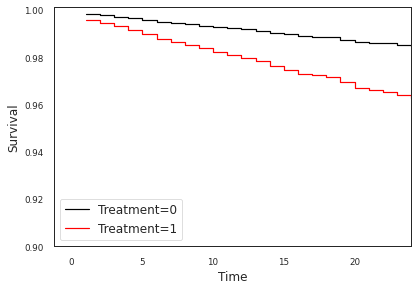

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       42.955545  5.599795e-11  34.055835

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.816           0.530        3.423    0.001
Total Cost                       -0.015           0.027       -0.561    0.575
Gender                            0.239           0.153        1.565    0.118
Tobacco Use                      -0.012           0.242       -0.050    0.960
Pressure                         -1.160           1.031       -1.125    0.261
Obesity                           0.756           0.155        4.866    0.000
Hypertension                     -0.077           0.158       -0.487    0.626
Hypothyroid                      -0.329           0.218       -1.509    0.131
Disease Count                     3.436           0.579        5.938    0.000
Acute Care 2 Months               0.642           0.362        1.772    0.076
Acute Care 6 Months               0.113           0.903        0.125    0.900
Inpatient Visits 6 Months        -0.257           0.800       -0.321    0.748
Emergency Vistits 6 Months       -0.184           0.846       -0.217    0.828
Line of Bussiness                -0.034           0.259       -0.132    0.895
Treatment                         0.901           0.139        6.502    0.000

### ER

data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
treated.columns

Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTE

In [17]:
%%time
onset = 'ER_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, 
                                                 grace = grace, 
                                                 onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset,
                                                  grace = grace).reset_index(drop = True).dropna(axis = 0,subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 53.2 ms, total: 12.2 s
Wall time: 12.2 s


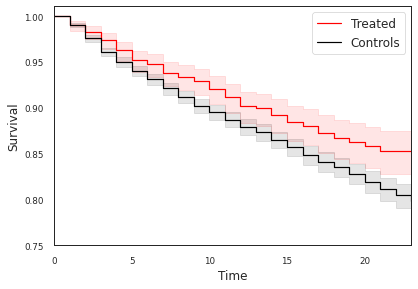

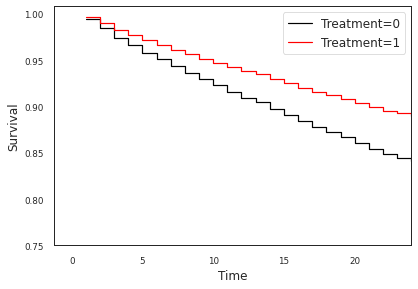

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.75]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        7.997825  0.004683  7.738241

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.905           0.233       -3.881    0.000
Total Cost                        0.044           0.012        3.516    0.000
Gender                           -0.025           0.078       -0.324    0.746
Tobacco Use                       0.186           0.105        1.760    0.078
Pressure                         -0.368           0.476       -0.773    0.439
Obesity                           0.040           0.066        0.609    0.542
Hypertension                      0.156           0.078        1.988    0.047
Hypothyroid                      -0.124           0.113       -1.101    0.271
Disease Count                     0.705           0.309        2.286    0.022
Acute Care 2 Months               1.379           0.146        9.444    0.000
Acute Care 6 Months               0.028           0.338        0.082    0.934
Inpatient Visits 6 Months        -0.340           0.266       -1.279    0.201
Emergency Vistits 6 Months        0.700           0.317        2.209    0.027
Line of Bussiness                -0.578           0.091       -6.354    0.000
Treatment                        -0.396           0.088       -4.476    0.000

### IP

data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 57.2 ms, total: 12.2 s
Wall time: 12.2 s


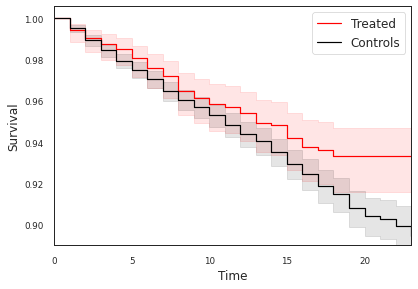

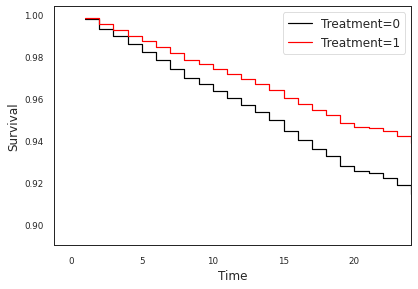

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.89]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [23]:
lrsumm

test_statistic        p  -log2(p)
Inpatient Visits         4.19055  0.04065  4.620604

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.293           0.331        3.901    0.000
Total Cost                        0.112           0.019        5.789    0.000
Gender                           -0.073           0.110       -0.668    0.504
Tobacco Use                       0.088           0.157        0.561    0.575
Pressure                         -0.530           0.451       -1.176    0.240
Obesity                           0.028           0.092        0.309    0.758
Hypertension                      0.023           0.107        0.219    0.826
Hypothyroid                      -0.315           0.148       -2.129    0.033
Disease Count                     1.848           0.392        4.710    0.000
Acute Care 2 Months               1.399           0.185        7.573    0.000
Acute Care 6 Months              -0.101           0.391       -0.259    0.796
Inpatient Visits 6 Months         0.983           0.349        2.813    0.005
Emergency Vistits 6 Months       -0.072           0.356       -0.203    0.839
Line of Bussiness                -0.360           0.147       -2.455    0.014
Treatment                        -0.347           0.123       -2.810    0.005

### Acute Care IP OR ER

data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [25]:
%%time
onset = 'ACUTE'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12 s, sys: 43.3 ms, total: 12.1 s
Wall time: 12.1 s


In [26]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
4     2619378   3  1     0.0     0.0        1               78        399   
5     2621187  11  1     0.0     0.0        2               78      13007   
6     2623521  28  1     0.0     0.0        0               77          0   
16    2651688   4  1     0.0     0.0        0               74        179   
26    2668219   5  1     0.0     0.0        0               71        346   
...       ...  .. ..     ...     ...      ...              ...        ...   
1330  4390059   4  1     0.0     0.0        0               47          2   
1334  4398341  11  1     0.0     0.0        0               66          0   
1337  5001236  16  1     0.0     0.0        0               60        374   
1342  5003200   1  1     1.0     1.0        1               55       3137   
1348  5014675   3  1     0.0     0.0        1               26        409   

      ALLOW_ER  ALLOW_IP  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4          0.0       0.0  ...       0      0.0      0.0     0    1         1   
5          0.0       0.0  ...       0      0.0      0.0     0    1         1   
6          0.0       0.0  ...       0      0.0      0.0     0    1         0   
16         0.0       0.0  ...       0      0.0      0.0     0    1         1   
26         0.0       0.0  ...       0      0.0      0.0     0    1         0   
...        ...       ...  ...     ...      ...      ...   ...  ...       ...   
1330       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1334       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1337       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1342    1298.0       0.0  ...       0      0.0      0.0     0    1         0   
1348       0.0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
26        Medicare  201911        0.0          1  
...            ...     ...        ...        ...  
1330    Commercial  202002        0.0          1  
1334      Medicare  202005        0.0          1  
1337    Commercial  202002        0.0          1  
1342    Commercial  202005        0.0          1  
1348    Commercial  202010        0.0          1  

[212 rows x 94 columns]

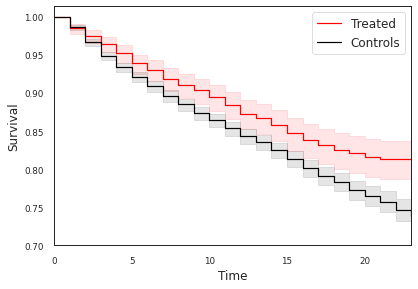

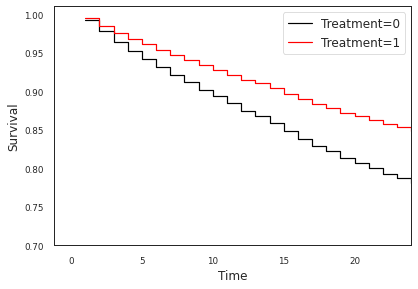

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [28]:
lrsumm

test_statistic         p  -log2(p)
Acute Care        9.992877  0.001571   9.31367

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.235           0.203       -1.158    0.247
Total Cost                        0.067           0.011        6.024    0.000
Gender                           -0.017           0.068       -0.252    0.801
Tobacco Use                       0.126           0.096        1.312    0.189
Pressure                         -0.026           0.334       -0.076    0.939
Obesity                           0.014           0.058        0.240    0.811
Hypertension                      0.110           0.068        1.615    0.106
Hypothyroid                      -0.208           0.097       -2.151    0.031
Disease Count                     0.985           0.268        3.679    0.000
Acute Care 2 Months               1.666           0.126       13.194    0.000
Acute Care 6 Months               0.534           0.300        1.783    0.075
Inpatient Visits 6 Months        -0.115           0.253       -0.456    0.649
Emergency Vistits 6 Months       -0.021           0.280       -0.074    0.941
Line of Bussiness                -0.558           0.083       -6.757    0.000
Treatment                        -0.412           0.077       -5.366    0.000

### Acute Care  diff and diff calculation

In [30]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls_all = pd.read_pickle(p+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 12.1 s, sys: 19 s, total: 31.1 s
Wall time: 32.1 s


In [31]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), controls_all.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

try:
    controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    controls2 = controls2
try:
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    treated2 = treated2
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
#for d in data2:
#    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 27 s, sys: 2.67 s, total: 29.7 s
Wall time: 29.7 s


In [32]:
treated2.shape, controls2.shape

In [33]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [34]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [35]:
%%time
times = [0]
onset = 'ACUTE'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.2 s, sys: 85.9 ms, total: 12.3 s
Wall time: 12.3 s


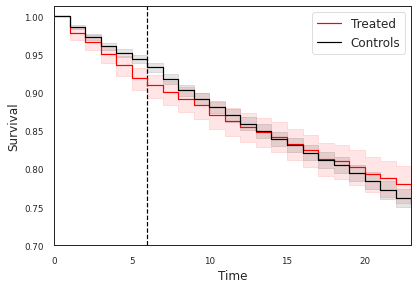

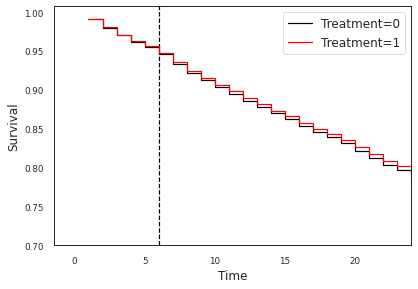

In [36]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [37]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd        1.017229  0.313177  1.674949

In [38]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.131           0.187       -0.702    0.483
Total Cost                        0.063           0.010        6.311    0.000
Gender                            0.004           0.062        0.066    0.948
Tobacco Use                      -0.005           0.091       -0.050    0.960
Pressure                          0.075           0.292        0.258    0.796
Obesity                          -0.089           0.053       -1.693    0.090
Hypertension                     -0.024           0.062       -0.392    0.695
Hypothyroid                      -0.008           0.085       -0.100    0.921
Disease Count                     1.746           0.243        7.181    0.000
Acute Care 2 Months               1.320           0.104       12.708    0.000
Acute Care 6 Months               0.722           0.267        2.702    0.007
Inpatient Visits 6 Months        -0.674           0.242       -2.778    0.005
Emergency Vistits 6 Months       -0.207           0.253       -0.818    0.414
Line of Bussiness                -0.632           0.076       -8.329    0.000
Treatment                        -0.028           0.066       -0.424    0.671

### Load all Log Rank Sums in a matrix

In [39]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [40]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      42.96                  0.00   
Emergency Visits               8.00                  0.00   
Inpatient Vistis               4.19                  0.04   
Acute Care                     9.99                  0.00   
Acute Care DD                  1.02                  0.31   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.15   
Emergency Visits                            0.04   
Inpatient Vistis                            0.01   
Acute Care                                  0.06   
Acute Care DD                              -0.06   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.32   
Emergency Visits                             0.18   
Inpatient Vistis                             0.05   
Acute Care                                   0.22   
Acute Care DD                               -0.14   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.51   
Emergency Visits                             0.34   
Inpatient Vistis                             0.12   
Acute Care                                   0.43   
Acute Care DD                               -0.14   

                  RMST Difference After 24 Months  
Diabetes                                    -0.73  
Emergency Visits                             0.59  
Inpatient Vistis                             0.30  
Acute Care                                   0.77  
Acute Care DD                               -0.06